In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import gensim
%matplotlib inline

# Exploratory Data Analysis + Word2Vec
This notebook we will be exploring the Kaggle online jobs description dataset.
Our overall purpose is to find entities that describe job requirements and responsibilies.

We are also going to test out a very naive Word2Vec just as a tutorial (learning this for first time too).

In [2]:
df = pd.read_csv('data/data job posts.csv')
print(len(df))

19001


In [3]:
df[:5]

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\r\n...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\r\n- CV; \...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [4]:
print(df.columns)

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')


Cool, for a start let's remove everything where JobRequirement or RequiredQual is NaN. There's also an annoying typo for job requirement so we will fix that as well.

In [5]:
df = df.dropna(how = 'all', subset=['JobRequirment', 'RequiredQual', 'JobDescription']) 
df.rename(columns={'JobRequirment':'JobRequirement'}, inplace=True)

In [6]:
df["JobRequirement"][:5]

0    - Supervises financial management and administ...
1                                                  NaN
2    - Working with the Country Director to provide...
3    - Identify gaps in knowledge and overseeing in...
4    - Rendering technical assistance to Database M...
Name: JobRequirement, dtype: object

Now, we'll drop all columns we don't care about.

In [7]:
df = df.drop(columns = ['jobpost', 'date', 'Company', 'AnnouncementCode', 'Term', 'Audience', 'StartDate', 'AboutC', 
                        'Attach', 'Location', 'Salary', 'ApplicationP', 'ApplicationP', 'OpeningDate', 'Deadline', 'Notes',
                        'Year', 'Month', 'IT', 'Duration'])

In [8]:
df[:5]

,Title,Eligibility,JobDescription,JobRequirement,RequiredQual
0,Chief Financial Officer,NaN,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\r\nindivi..."
1,Full-time Community Connections Intern (paid i...,NaN,NaN,NaN,- Bachelor's Degree; Master's is preferred;\r\...
2,Country Coordinator,NaN,Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ..."
3,BCC Specialist,NaN,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci..."
4,Software Developer,NaN,NaN,- Rendering technical assistance to Database M...,- University degree; economical background is ...


In [9]:
df['Eligibility'].notnull()[:5]


0    False
1    False
2    False
3    False
4    False
Name: Eligibility, dtype: bool

In [10]:
df["RequiredQual"][0]

"To perform this job successfully, an\r\nindividual must be able to perform each essential duty satisfactorily.\r\nThe requirements listed below are representative of the knowledge,\r\nskill, and/or ability required.\r\nKnowledge of:\r\n- Generally accepted accounting principles;\r\n- Local accounting standards and legislation;\r\n- State reporting requirements pertaining to accounting;\r\n- Principles and practices of financial management and budgeting;\r\n- Principles and practices of financial systems design and analysis;\r\n- Principles and practices of contract management, records management,\r\nand risk management;\r\n- Principles and practices of management and supervision;\r\n- Principles and practices of information systems management.\r\nAbility to:\r\n- Apply sound fiscal and administrative practices to the company's\r\nactivities;\r\n- Plan, organize and supervise the work of subordinate employees,\r\nincluding training them, assigning and evaluating their work, and\r\nprov

# Word2Vec simple model
For now, we are going to just focus on RequiredQual and build a word embedding out of that. We are also going to save this cleaner dataset for now.


In [11]:
df.to_csv("data/job_dataset_4_4.csv", index=False)

In [12]:
# drop NaN required quals
df = df.dropna(subset=['RequiredQual']) 
job_requirements = df["RequiredQual"].tolist()

In [13]:
job_requirements[0]

"To perform this job successfully, an\r\nindividual must be able to perform each essential duty satisfactorily.\r\nThe requirements listed below are representative of the knowledge,\r\nskill, and/or ability required.\r\nKnowledge of:\r\n- Generally accepted accounting principles;\r\n- Local accounting standards and legislation;\r\n- State reporting requirements pertaining to accounting;\r\n- Principles and practices of financial management and budgeting;\r\n- Principles and practices of financial systems design and analysis;\r\n- Principles and practices of contract management, records management,\r\nand risk management;\r\n- Principles and practices of management and supervision;\r\n- Principles and practices of information systems management.\r\nAbility to:\r\n- Apply sound fiscal and administrative practices to the company's\r\nactivities;\r\n- Plan, organize and supervise the work of subordinate employees,\r\nincluding training them, assigning and evaluating their work, and\r\nprov

In [14]:
# Use Gensim to preprocess each doc

In [15]:
processed_jobs = []
for job in job_requirements:
    tokens = gensim.utils.simple_preprocess(job)
    processed_jobs.append(tokens)


In [16]:
model = gensim.models.Word2Vec(
        processed_jobs,
        size=150,
        window=10,
        min_count=2,
        workers=3)
model.train(processed_jobs, total_examples=len(processed_jobs), epochs=10)

(8789630, 13485690)

In [17]:
w1 = "leader"
model.wv.most_similar(positive = w1)

[('member', 0.6820858716964722),
 ('guide', 0.6009737253189087),
 ('part', 0.5653370022773743),
 ('worker', 0.5168100595474243),
 ('members', 0.5118786692619324),
 ('productively', 0.49776482582092285),
 ('adviser', 0.49744856357574463),
 ('capable', 0.49231112003326416),
 ('individual', 0.4875674247741699),
 ('act', 0.4874846935272217)]

In [9]:
w1 = "creative"
model.wv.most_similar(positive = w1)

[('proactive', 0.6037420630455017),
 ('innovative', 0.5682332515716553),
 ('influential', 0.5181764364242554),
 ('analytic', 0.5023798942565918),
 ('creativity', 0.4862079322338104),
 ('conceptual', 0.4842992126941681),
 ('forward', 0.4720326364040375),
 ('outgoing', 0.4706800878047943),
 ('analytical', 0.4679693877696991),
 ('persuasive', 0.4638703763484955)]

In [16]:
w1 = "collaborate"
model.wv.most_similar(positive = w1)

[('developers', 0.7458773255348206),
 ('members', 0.5263158082962036),
 ('group', 0.5235828161239624),
 ('closely', 0.5190879106521606),
 ('collaboratively', 0.5004623532295227),
 ('interact', 0.4970906674861908),
 ('roadblocks', 0.48179203271865845),
 ('liaise', 0.4766513705253601),
 ('communicate', 0.4602963328361511),
 ('stakeholders', 0.4544546604156494)]

In [13]:
w1 = "quantitative"
model.wv.most_similar(positive = w1)

[('qualitative', 0.7259106636047363),
 ('econometric', 0.6138638854026794),
 ('surveys', 0.6035459637641907),
 ('statistical', 0.5964557528495789),
 ('research', 0.5825209617614746),
 ('spread', 0.5511327385902405),
 ('collection', 0.5343617796897888),
 ('analysis', 0.5073949694633484),
 ('models', 0.4864950478076935),
 ('analyzing', 0.4845603406429291)]

In [15]:
w1 = "presentation"
model.wv.most_similar(positive = w1)

[('negotiation', 0.4502134919166565),
 ('inter', 0.41458484530448914),
 ('influencing', 0.392049103975296),
 ('negotiating', 0.3839283883571625),
 ('leadership', 0.371124267578125),
 ('interpersonal', 0.3600274920463562),
 ('skills', 0.35602888464927673),
 ('listening', 0.34992319345474243),
 ('organizational', 0.3326420187950134),
 ('teambuilding', 0.331294447183609)]

In [18]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE

In [53]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,150), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(-1000, 500)
    plt.ylim(-1000, 500)
    plt.show()

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


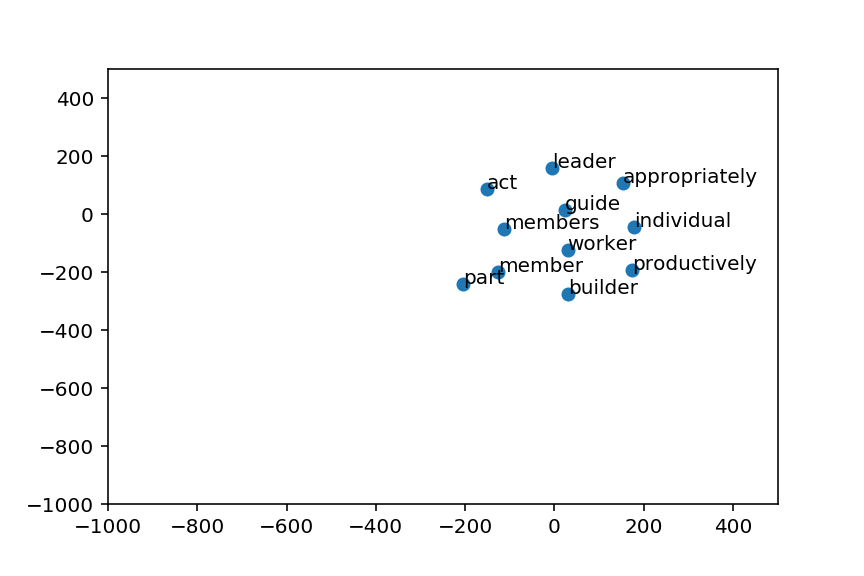

In [56]:
display_closestwords_tsnescatterplot(model, 'leader')


In [25]:
len(model['leader'])

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


150

In [67]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in ["leader", "member", "guide", "econometric", "negotiation", "inter", "influencing", "organizational", "teambuilding", "analyzing", "analysis", "model", "interact", "roadblocks", "listening", "interpersonal", "liaise", "statistical", "research", "innovative", "creative", "analysis", "communicate", "stakeholders", "group", "developers", "conceptual", "forward", "builder", "collaborate", "code", "quantitative", "speaking"]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


<IPython.core.display.Javascript object>


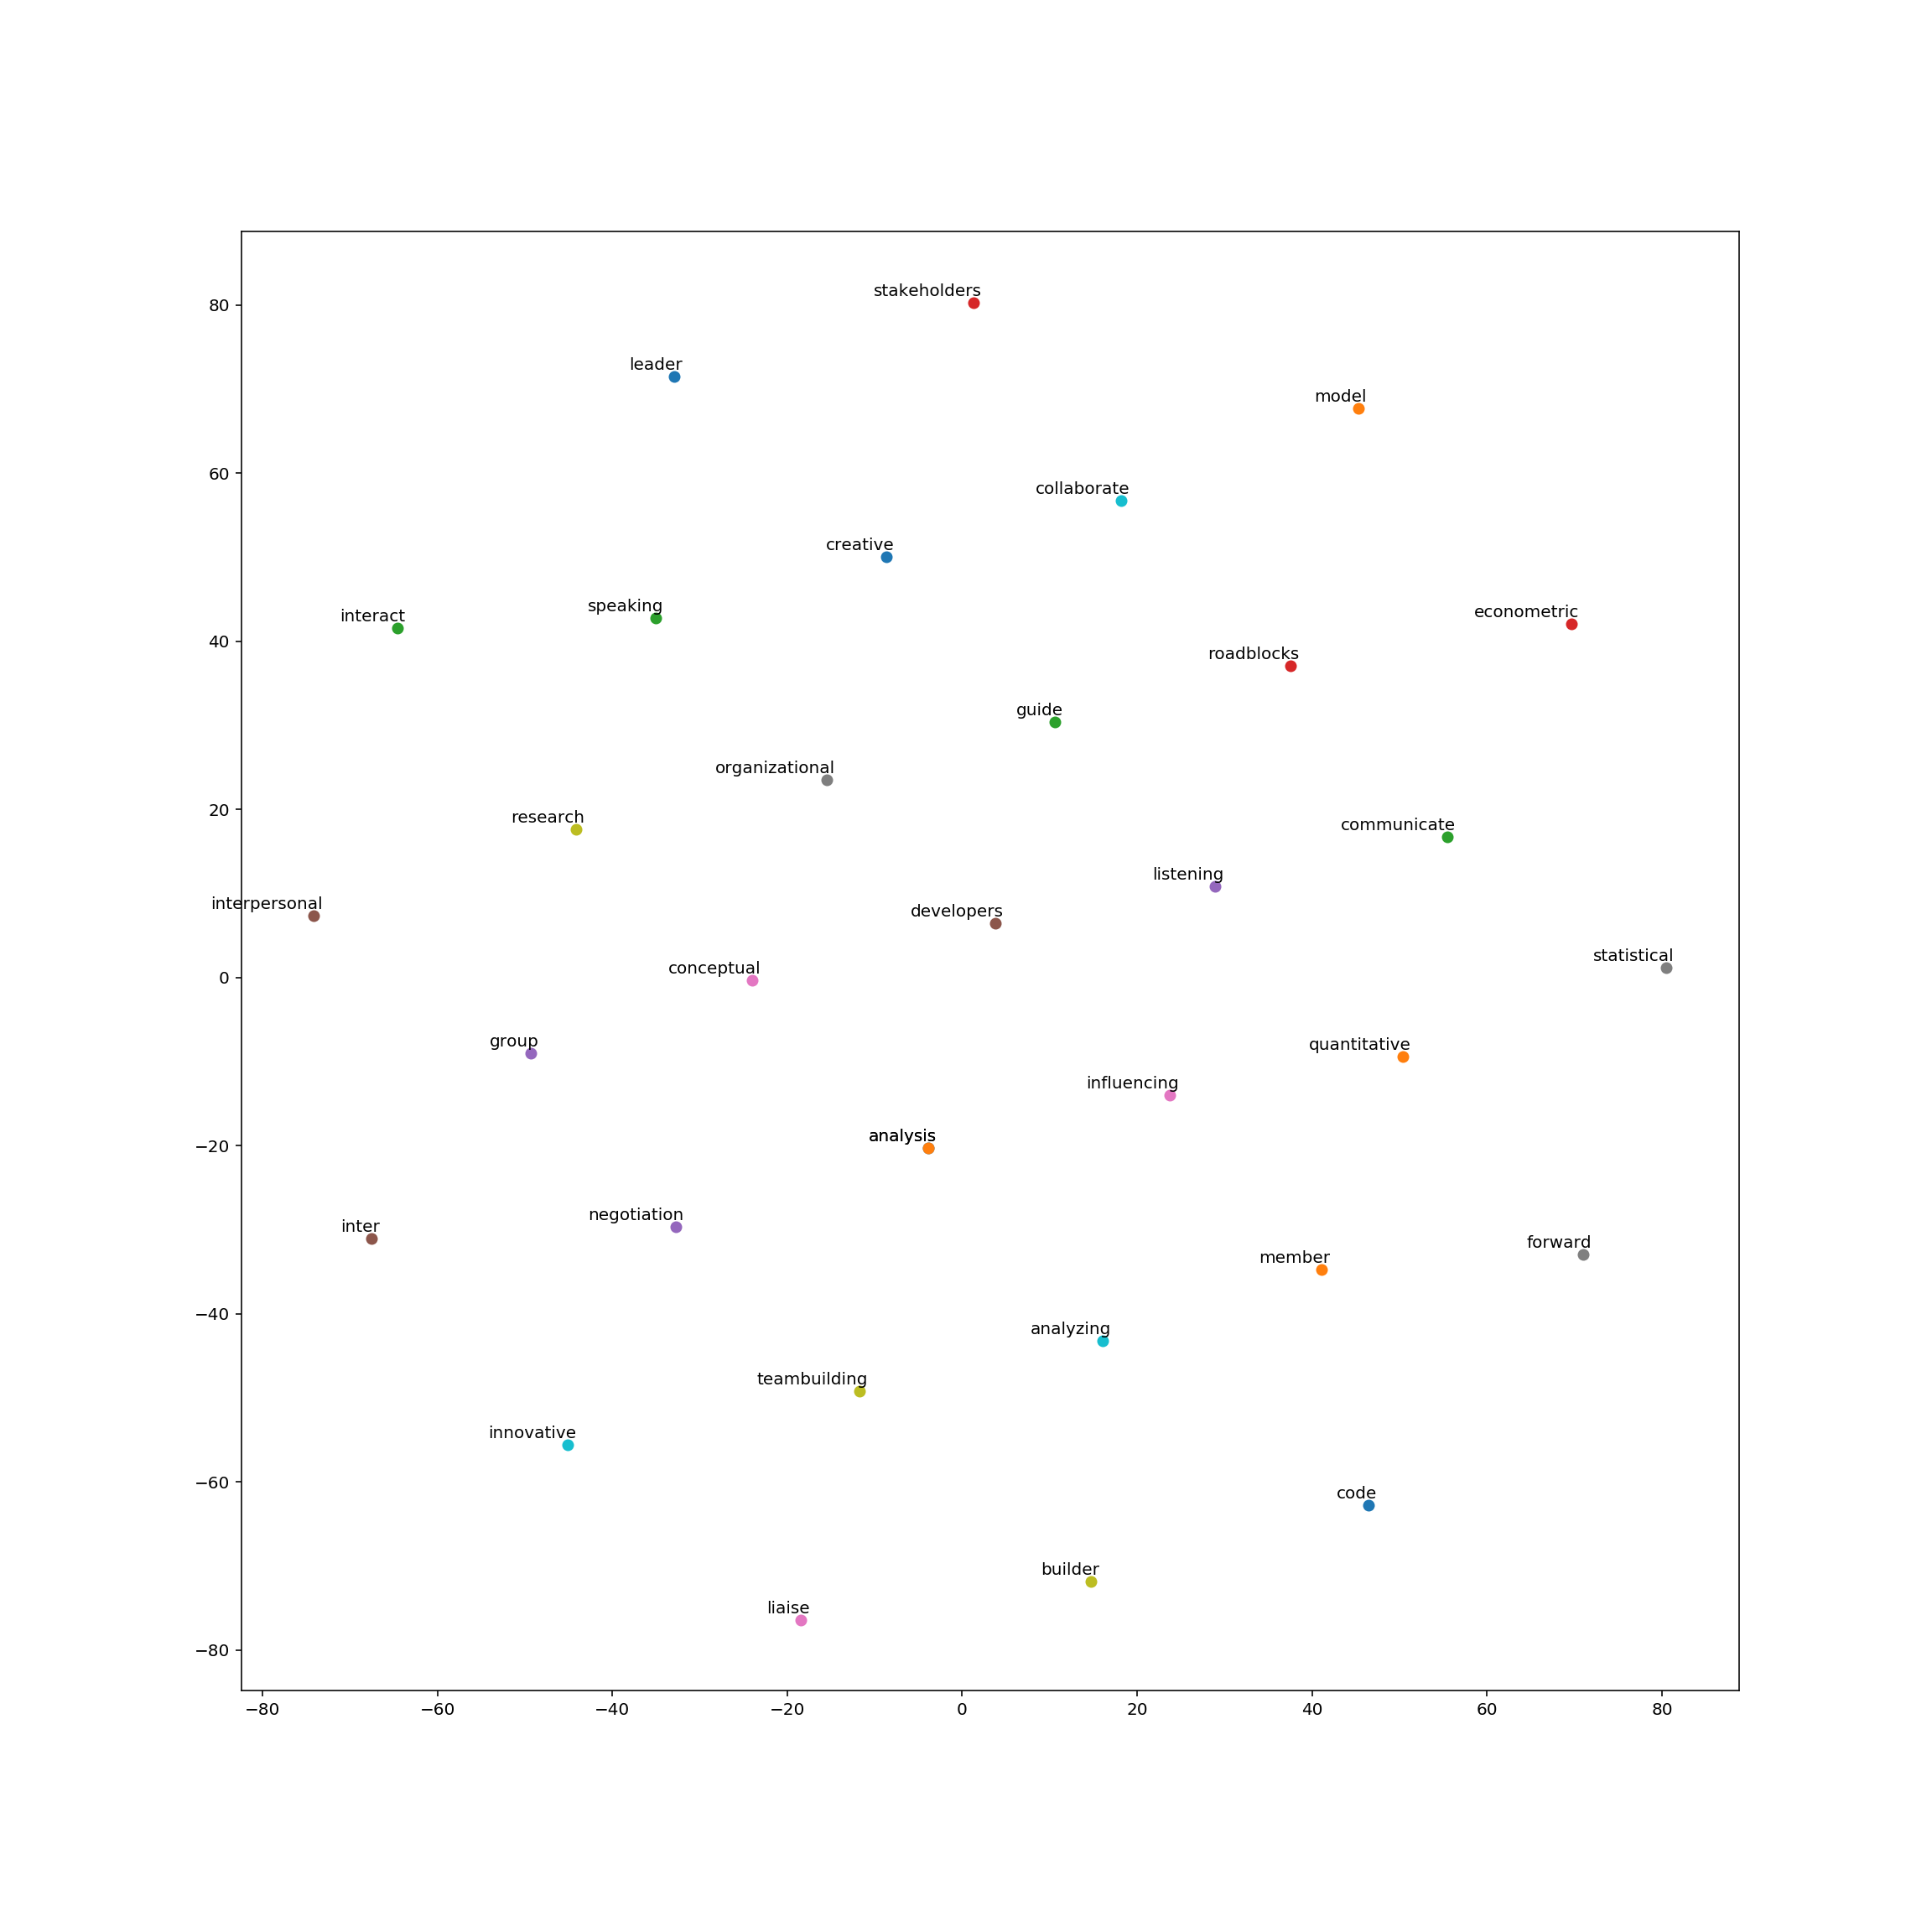

In [68]:
tsne_plot(model)

In [49]:
desc = "Led teambuilding division to lead and motivate students 123."
desc = gensim.parsing.preprocessing.remove_stopwords(desc)
desc = gensim.parsing.preprocessing.strip_numeric(desc)
desc = gensim.parsing.preprocessing.strip_punctuation(desc)
tokens = gensim.utils.simple_preprocess(desc)

# order: leadership, collaborate, creativity, quantitative
scores = [0, 0, 0, 0]
skills = ["leadership", "collaboration", "creativity", "quantitative"]
for word in tokens:
    scores[0] += model.similarity(word, "leadership")
    scores[1] += model.similarity(word, "collaborate")
    scores[2] += model.similarity(word, "creativity")
    scores[3] += model.similarity(word, "math")
max_score = max(scores)
skill = skills[scores.index(max_score)]
print(max_score)
print(skill)
    


1.11983140418306
leadership


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  if sys.path[0] == '':
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  del sys.path[0]
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


In [56]:
def score_experience(desc):
    desc = "Led teambuilding division to lead and motivate students 123."
    desc = gensim.parsing.preprocessing.remove_stopwords(desc)
    desc = gensim.parsing.preprocessing.strip_numeric(desc)
    desc = gensim.parsing.preprocessing.strip_punctuation(desc)
    tokens = gensim.utils.simple_preprocess(desc)

    # order: leadership, collaborate, creativity, quantitative
    scores = [0, 0, 0, 0]
    skills = ["leadership", "collaboration", "creativity", "quantitative"]
    for word in tokens:
        scores[0] += model.wv.similarity(word, "leadership")
        scores[1] += model.wv.similarity(word, "collaborate")
        scores[2] += model.wv.similarity(word, "creativity")
        scores[3] += model.wv.similarity(word, "math")
    max_score = max(scores)
    skill = skills[scores.index(max_score)]
    if max_score < 0.1:
        return None
    else:
        return (skill, max_score)

In [57]:
score_experience("Led teambuilding division to lead and motivate students 123.")

('leadership', 1.11983140418306)